In [107]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.linalg import expm
from scipy.linalg import eig
import scipy.linalg
import matplotlib.pyplot as plt
import control

import Modified_FourTank_functions as fun   # Import functions
from Modified_FourTank_parameters import p, a1, a2, a3, a4, A1, A2, A3, A4, g, gamma1, gamma2, rho  # Import parameters

Modified 4tank system

# Problem 2
Deterministic and Stochastic Nonlinear Modeling

## 2.1 Deterministic Nonlinear Model

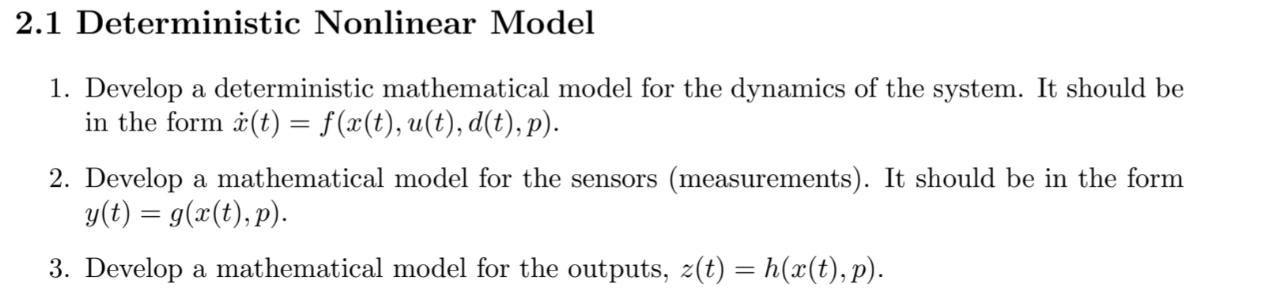

See "Modified_FourTanksystem" function

See "FourTankSystemSensor_Deterministic" function

See "FourTankSystemOutput" function

- What is the difference on sensor and output? and should we use level or mass?


## 2.2 Stochastic Nonlinear Model

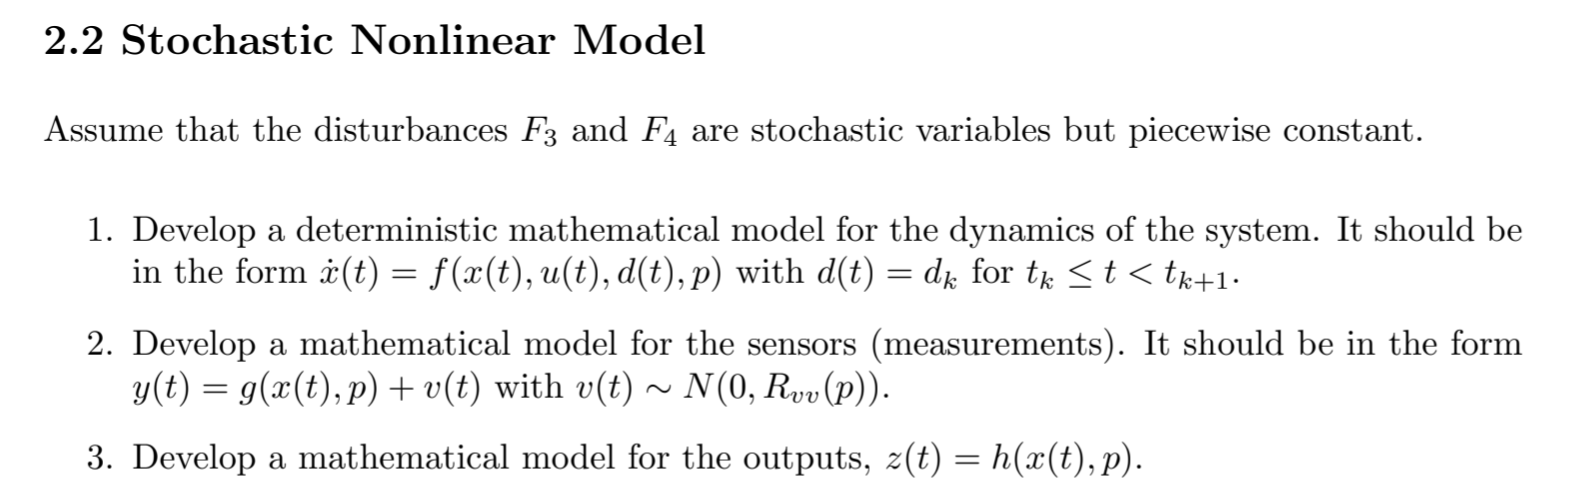

1. See "run_step" function
2. See "FourTankSystemSensor" function
3. See "FourTankSystemOutput" function

## 2.3 Stochastic Nonlinear Model (SDE)

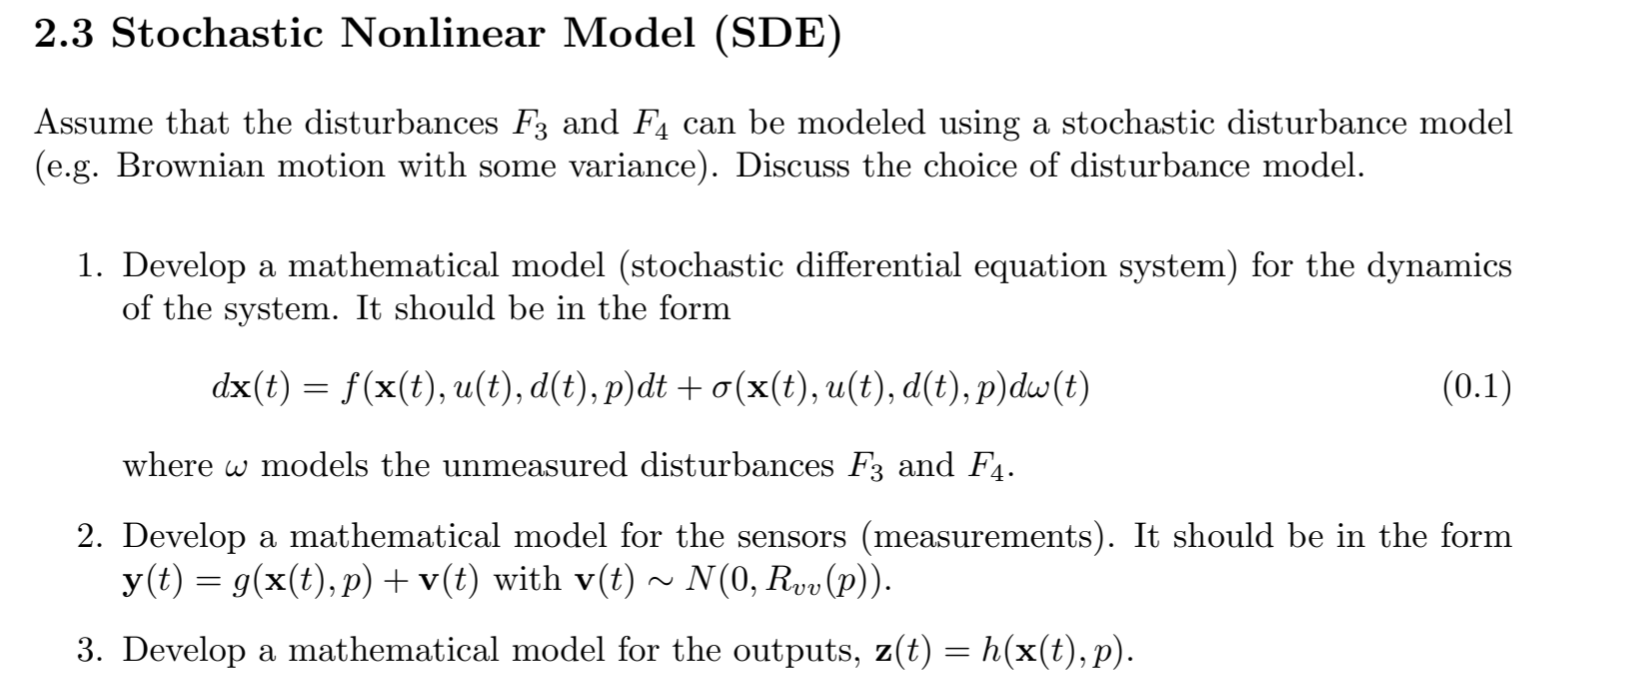

$$
dm_1 = \rho(q_{1in} + q_3 - q_1)dt
$$
$$
dm_2 = \rho(q_{2in} + q_4 - q_2)dt
$$
$$
dm_3 = \rho(q_{3in} - q_3 + \bar{F_3})dt + \sigma_3 d\omega
$$
$$
dm_4 = \rho(q_{4in} - q_4 + \bar{F_4})dt + \sigma_4 d\omega
$$

## 2.4 Simulation

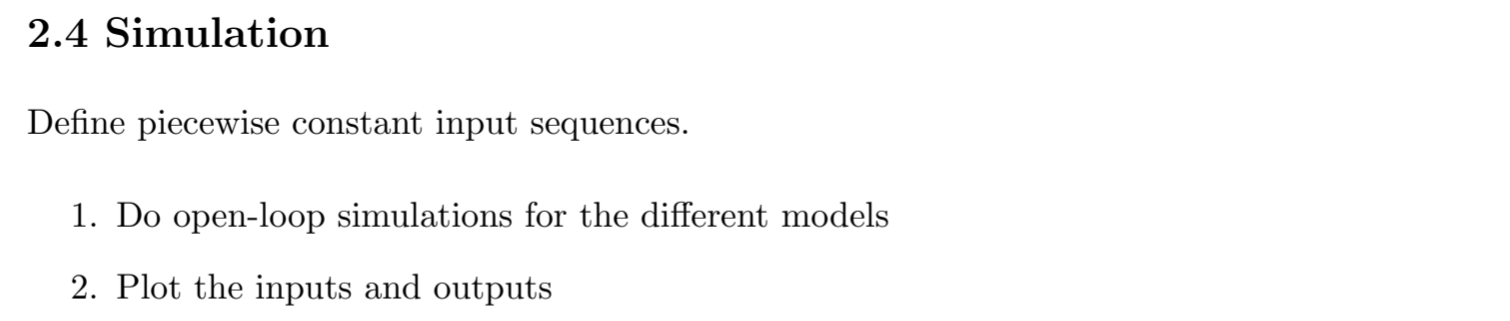

### For model 2.2

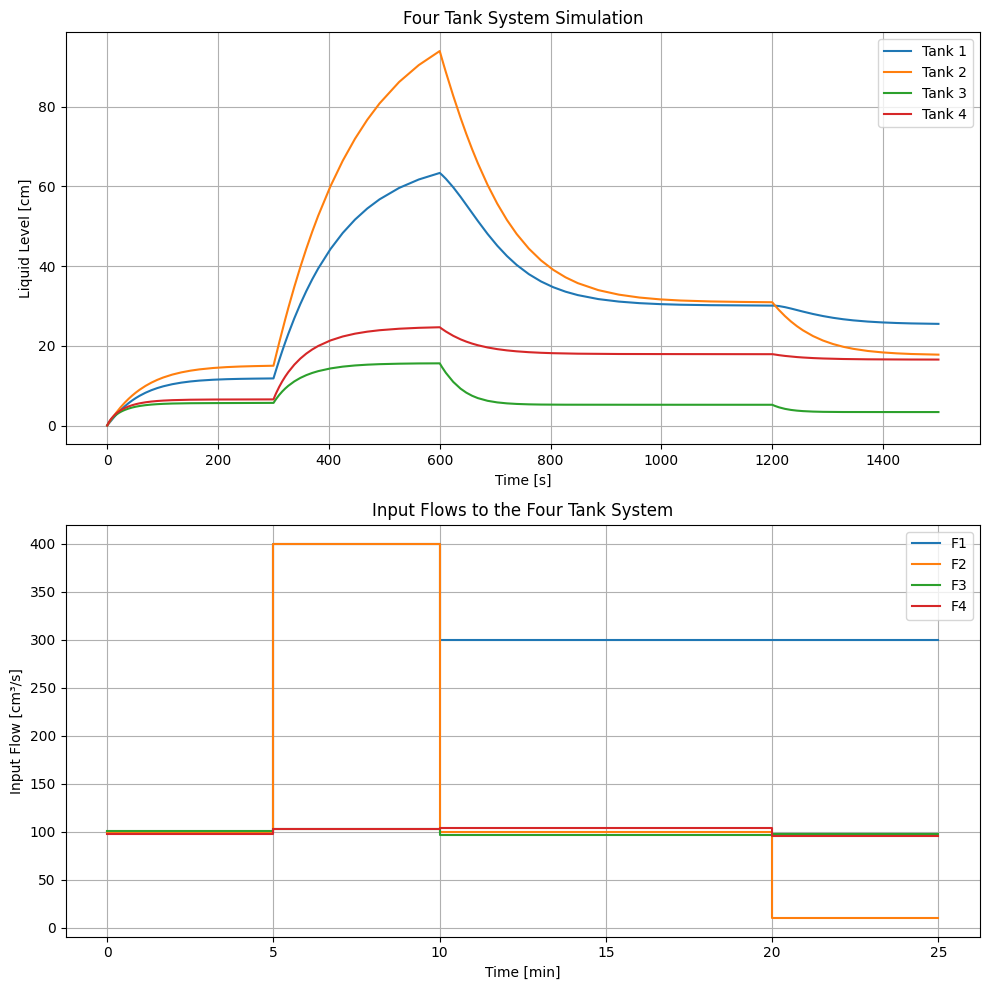

In [108]:
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states
times = np.array([0,5,10,20,25])*60 # start and end of each interval
N = len(times)  # number of intervals
nx = len(x0)
F1 = np.array([100,400,300,300])
F2 = np.array([100,400,100,10])
F3 = np.array([100,100,100,100])
F4 = np.array([100,100,100,100])
u = np.array([F1,F2])
d = np.array([F3,F4])

x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, noise_level=5)


### For model 2.3 (still need plot of disturbance with noise)

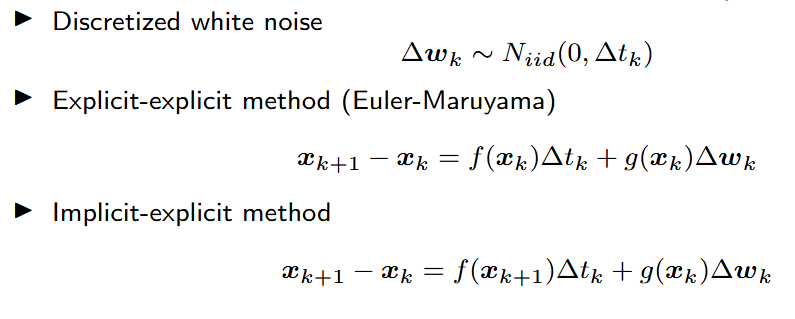

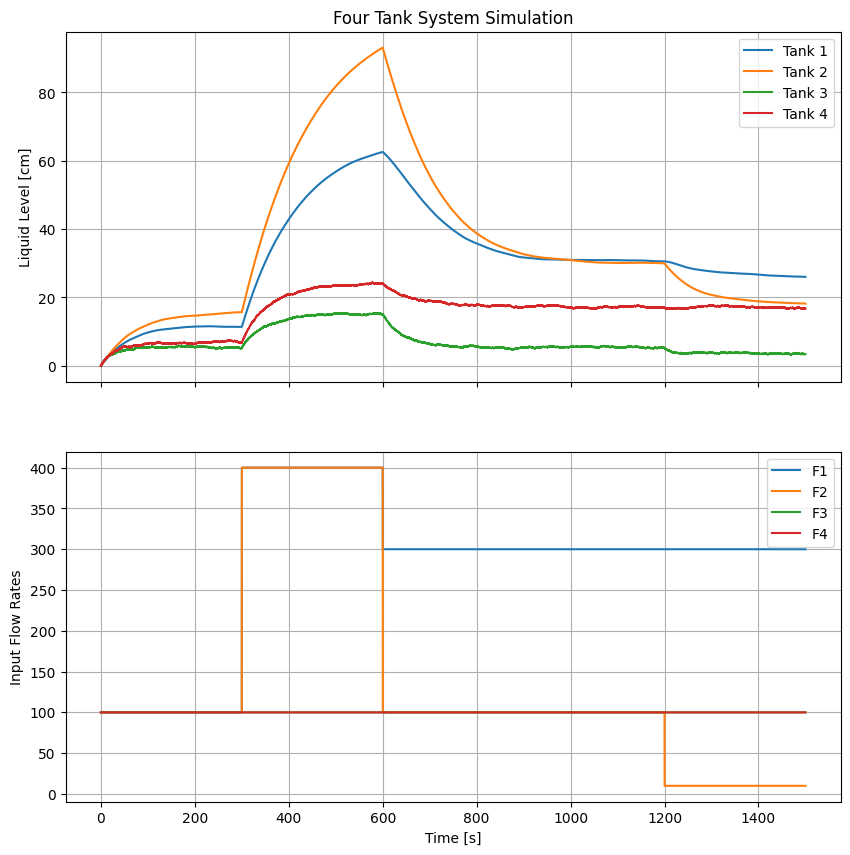

In [109]:
# --- Time and Noise Setup ---
times = np.array([0, 5, 10, 20, 25]) * 60  # in seconds
dt = 0.01

# --- Initial Conditions ---
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40
x0 = np.array([m10, m20, m30, m40])

# --- Input Profiles ---
F1 = np.array([100,400,300,300])
F2 = np.array([100,400,100,10])
F3 = np.array([100, 100, 100, 100])
F4 = np.array([100, 100, 100, 100])
u = np.array([F1, F2])
d = np.array([F3, F4])

x = fun.sim23(times, dt, x0, u, d, p, noise_level=20)

# Problem 3

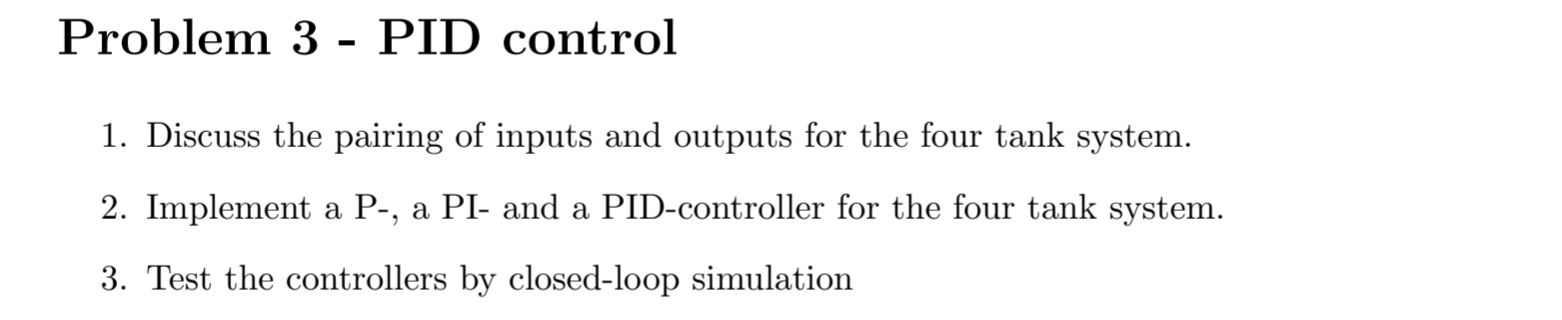

For controllers, steady state input need be known:
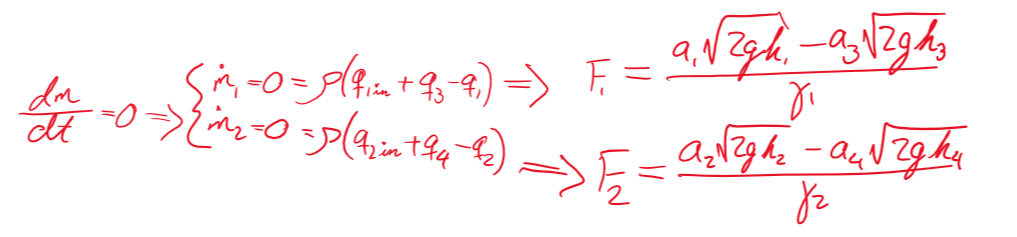

## For model 2.2
Kc is restricted by dt. Solver cannot handle if dt and Kc is too large.

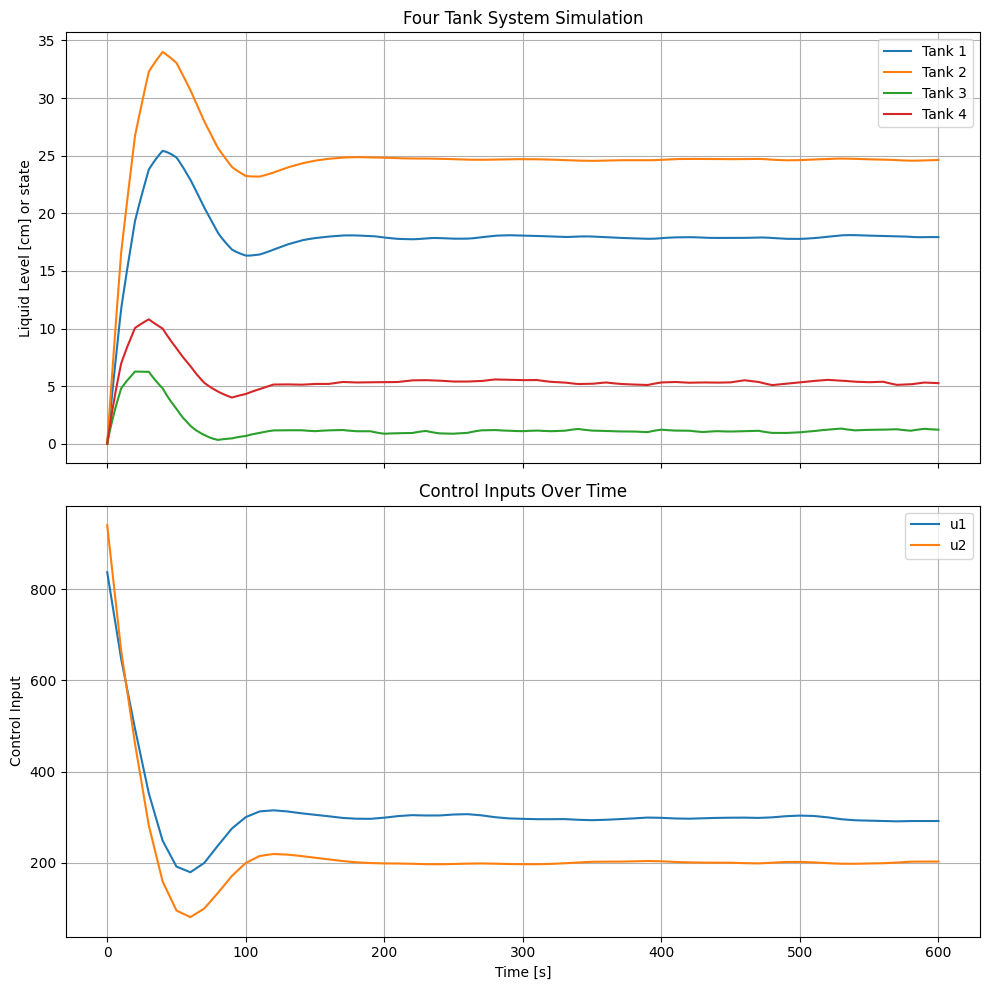

In [110]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = np.zeros([2,N-1])

r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

T_all, X_all, H_all, u, y, z = fun.closed_loop_sim22(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=5, Kc=10,Ki=1,Kd=100)

## For model 2.3

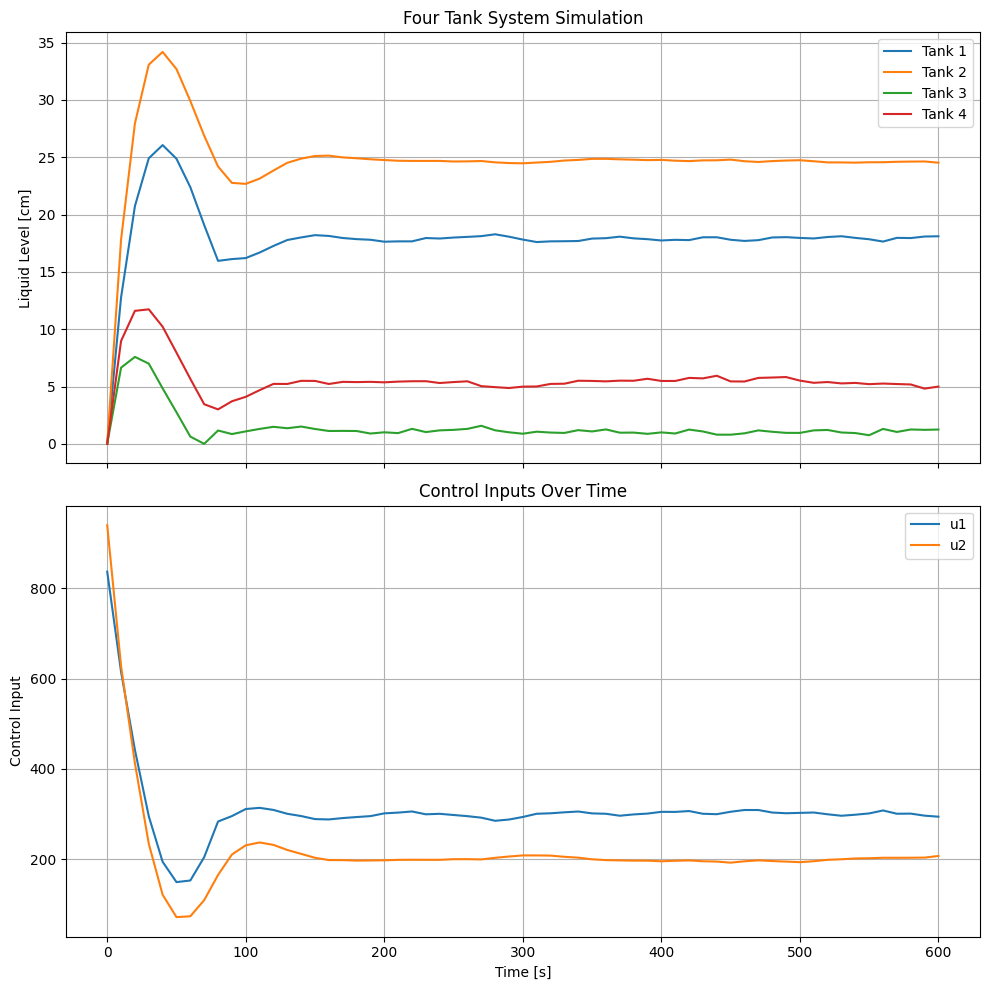

In [111]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = np.zeros([2,N-1])

r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

x, y, z, u = fun.closed_loop_sim23(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=20, Kc=10,Ki=1,Kd=100)

# Problem 4
Nonlinear Simulation - Step Responses (SHOULD IT BE WITH CONTROLLER?)

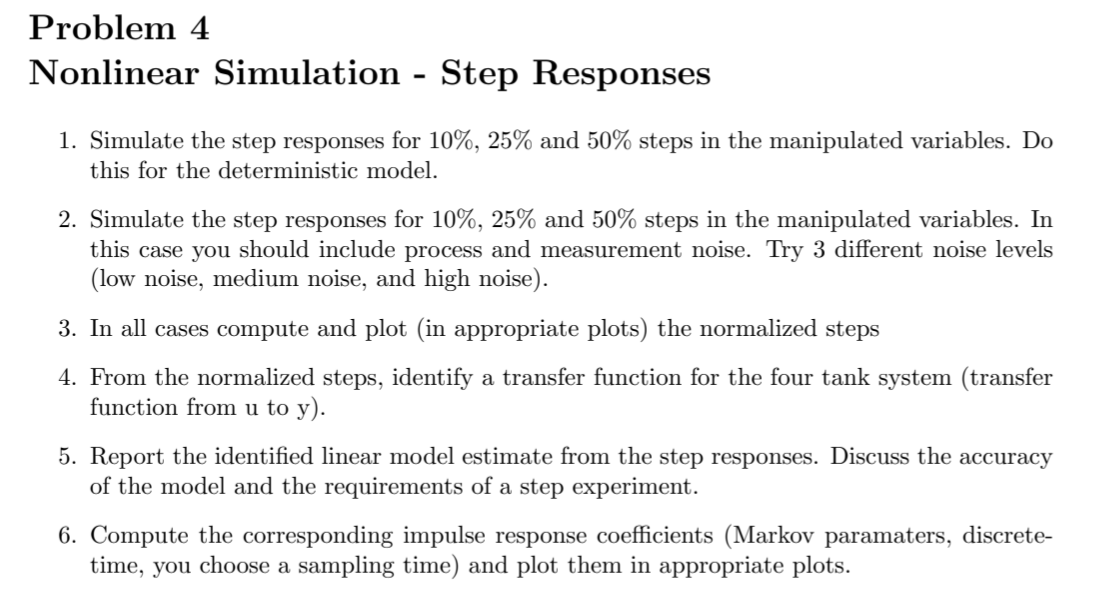

## For model 2.2 deterministic

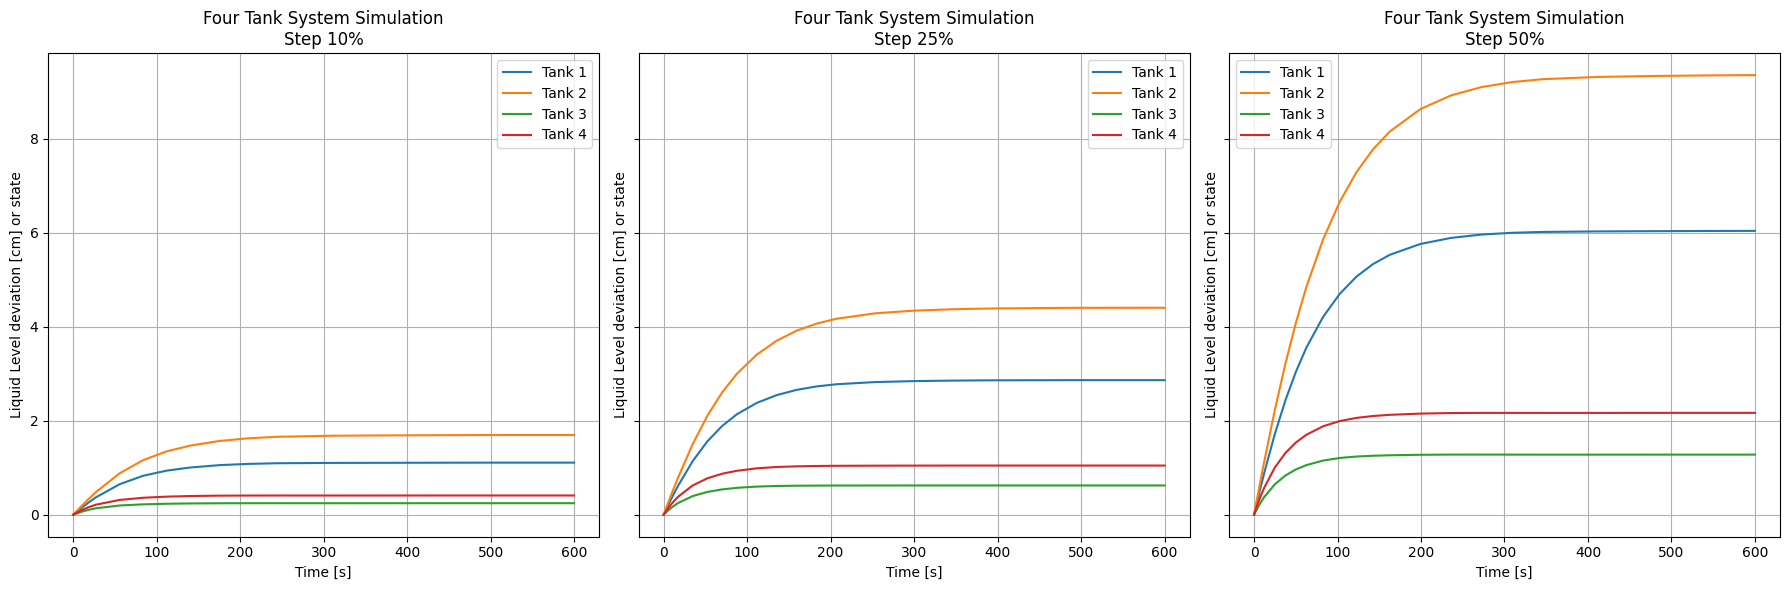

(4,)

In [112]:
noise_level=0
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states for first simulation
step_pers_list = [0.1, 0.25, 0.5]
results = []

fig, axs = plt.subplots(1, len(step_pers_list), figsize=(18, 6), sharey=True)

for idx, step_pers in enumerate(step_pers_list):
    # Define inputs
    F1 = np.array([100])
    F2 = np.array([100])
    F3 = np.array([100])
    F4 = np.array([100])
    u = np.array([F1, F2])
    d = np.array([F3, F4])

    # Run simulation 1 to get steady state
    times = np.array([0,10])*60
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, noise_level=noise_level, plot=False)
    x0 = X_all[-1,:].flatten()  # new IV
    h0 = H_all[-1,:].flatten()  # new IV

    # Run simulation
    F1 = F1 * (1 + step_pers)
    F2 = F2 * (1 + step_pers)
    u = np.array([F1, F2])
    d = np.array([F3, F4])
    times = np.array([0,10])*60
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, noise_level=noise_level, plot=False)
    results.append(x)

    # Extract parameters
    A = p[4:8]
    rho = p[11]
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # Plotting directly in the loop
    if H_all.shape[0] > 0:
        if H_all.shape[1] >= 4:
            axs[idx].plot(T_all.flatten(), H_all[:, 0]-h0[0], label='Tank 1')
            axs[idx].plot(T_all.flatten(), H_all[:, 1]-h0[1], label='Tank 2')
            axs[idx].plot(T_all.flatten(), H_all[:, 2]-h0[2], label='Tank 3')
            axs[idx].plot(T_all.flatten(), H_all[:, 3]-h0[3], label='Tank 4')
        else:
            axs[idx].plot(T_all.flatten(), X_all[:, 0], label='State 1')
            for i in range(1, min(4, X_all.shape[1])):
                axs[idx].plot(T_all.flatten(), X_all[:, i]-x0[i], label=f'State {i+1}')
    else:
        for i in range(4):
            h = x[i, :] / (rho * A[i])
            axs[idx].plot(t, h, label=f'Tank {i+1}')

    axs[idx].set_ylabel('Liquid Level deviation [cm] or state')
    axs[idx].set_title(f'Four Tank System Simulation\nStep {int(step_pers * 100)}%')
    axs[idx].set_xlabel('Time [s]')
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

X_all[-1,:].flatten().shape


## For model 2.3 deterministic

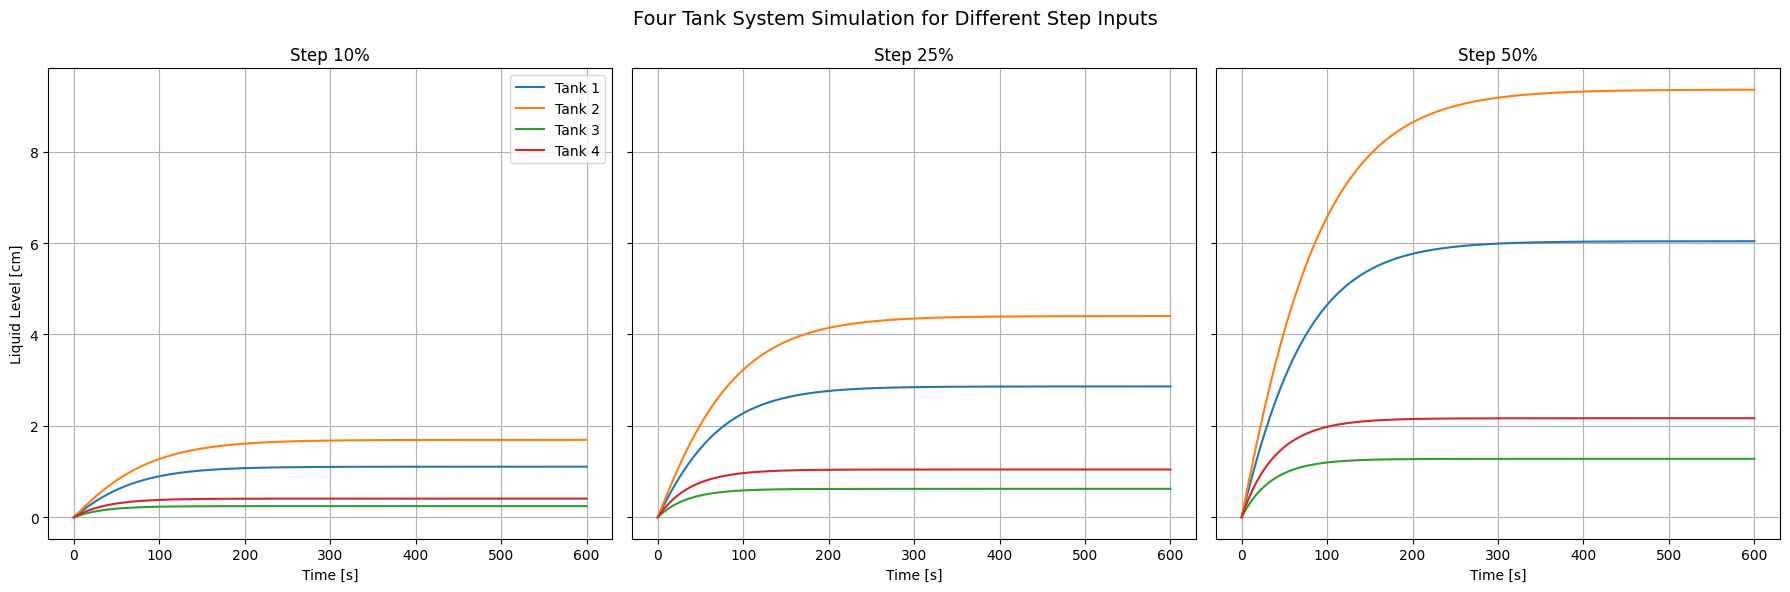

In [113]:
dt = 0.01
step_pers_list = [0.1, 0.25, 0.5]
results = []

fig, axs = plt.subplots(1, len(step_pers_list), figsize=(18, 6), sharey=True)

for idx, step_pers in enumerate(step_pers_list):
    # Define inputs
    F1 = np.array([100])
    F2 = np.array([100])
    F3 = np.array([100])
    F4 = np.array([100])
    u = np.array([F1, F2])
    d = np.array([F3, F4])

    # Run simulation 1 to get steady state
    times = np.array([0,10])*60
    x = fun.sim23(times, dt, x0, u, d, p, noise_level=noise_level, plot=False)
    x0 = x[:,-1].flatten()  # new IV

    # Run simulation
    F1 = F1 * (1 + step_pers)
    F2 = F2 * (1 + step_pers)
    u = np.array([F1, F2])
    d = np.array([F3, F4])
    times = np.array([0,10])*60
    x = fun.sim23(times, dt, x0, u, d, p, noise_level=noise_level, plot=False)
    
    """
    F1 = np.array([100, 100 * (1 + step_pers)])
    F2 = np.array([100, 100 * (1 + step_pers)])
    F3 = np.array([100, 100])
    F4 = np.array([100, 100])
    u = np.array([F1, F2])
    d = np.array([F3, F4])

    # Run simulation
    x = fun.sim23(times, dt, x0, u, d, p, noise_level=noise_level, plot=False)
    results.append(x)
    """
    # Extract parameters
    A = p[4:8]
    rho = p[11]
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # Plot liquid levels
    for i in range(4):
        h = (x[i, :] - x0[i]) / (rho * A[i])
        axs[idx].plot(t, h, label=f'Tank {i+1}')
    axs[idx].set_title(f'Step {int(step_pers*100)}%')
    axs[idx].set_xlabel('Time [s]')
    axs[idx].grid(True)

axs[0].set_ylabel('Liquid Level [cm]')
axs[0].legend(loc='upper right')
fig.suptitle('Four Tank System Simulation for Different Step Inputs', fontsize=14)
plt.tight_layout()
plt.show()
